In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-bards-best-a-character-modeling-dataset/validation.csv
/kaggle/input/the-bards-best-a-character-modeling-dataset/train.csv
/kaggle/input/the-bards-best-a-character-modeling-dataset/test.csv


<div style="box-shadow: rgba(0, 0, 0, 0.24) 0px 3px 8px; border-radius:3px; border-left-width:6px; border-left-color:gold; border-left-style:solid; margin:6px">
    <div style="padding:16px; background-color:rgb(6, 14, 25); margin:0px">
        <h1 style="margin:0; color:white">1 | About</h1>        
    </div>       
    <img src="https://wallpapercave.com/wp/wp6690890.jpg" style="margin-top:0px !important;"/>
    <div style="margin-top:6px; padding-left: 16px; padding-right:8px; padding-bottom:8px; padding-top:8px">
        <p style="margin-bottom:0">
This notebook is an implementation and explanation of a generative, decoder Transformer which, at the end, produces Shakespear-like plays.
<br/>
            The goal of this notebook is to understand how a Transformer is <b>really</b> built, layer by layer. Using pretrained 🤗 transformers is fine and unavoidable, but having built a Transformer on your own really helps to understand what you're actually doing when using them. <br/>This notebook wouldn't be possible without the following <b>excellent ressources</b> which I've followed and implemented step by step:<br/>
        </p>
           <ul style="margin-top:0; margin-left:16px">
               <li><a href="https://www.youtube.com/watch?v=kCc8FmEb1nY&t=5214s">Andrej Karpathy's Video Lecture</a></li>
               <li><a href="https://arxiv.org/abs/1706.03762">Attention Is All You Need</a></li>
               <li><a href="https://jalammar.github.io/illustrated-transformer/">Jay Alammar's Blog</a></li>
           </ul>
        <p>
            Also, a huge thank you to @gpreda for <a href="https://www.kaggle.com/discussions/general/478237#2659370">featuring and awarding</a> this notebook!
        </p>
        <p style="text-align:center">
            Without further ado, <b>let's dive into the notebook</b>.
        </p>
    </div>
</div>

# 2 | Prelude

-------------
>This section explains and implements general concepts needed which we will later on use to build the actual Transformer. **All the code within this Prelude section will be implemented later again, but without the explanations**. So, besides implementing the Transformer itself, if you want to learn what a Tokenizer is, how we define our vocabulary, what variables like batch_size and block_size are: work through this prelude. I certainly did.

-------------

**So**,
a Transformer is just a Neural Network architecture. Hence, they require numerical values as they cannot deal with text per se. One solution is therefore to represent each token(=chunk of text) within our text with a unique, numerical, identifier. Then, we write an **encoder**, which takes text and transforms them into numbers, and a **decoder**, which takes numbers and transforms them back to the original text.

## Dataset

For this notebook, we use the TinyShakespear dataset which has *40,000 lines of Shakespeare from a variety of Shakespeare's plays*. At the end, our Transformer will be able to produce Shakespear like plays.

In [2]:
with open('/kaggle/input/the-bards-best-a-character-modeling-dataset/train.csv', 'r', encoding='UTF-8') as f:
    text = f.read()
    
print("Dataset length: " + str(len(text)))
print("\nCheck the first characters in the dataset so you can see what's going on:")
print(text[:250])

Dataset length: 1003862

Check the first characters in the dataset so you can see what's going on:
text
"First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the pe


## Vocab
We firstly need to know how our vocab looks like. What unique characters are we dealing with? This is important for the encoding part as we will be given each token a unique id. 

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
66


We have 66 unique characters, which, for this transformer, results in 66 different token. **This is our vocab**, these are the tokens we can work with to formulate text. **For comparison:** GPT2 has a vocab size of 50.257 instead of 66. But since we train our Transformer only on one, small dataset, we don't need a super large vocab.

## Tokenizer

Below you can see a very simple tokenizer, which handles the encoder/decoder part explained earlier. It assigns each character a unique number, which we can later decode again. Normally, you wouldn't write your own tokenizer. Google e.g. uses [SentencePiece](https://github.com/google/sentencepiece) for their tokenizer tasks, which you could also use. Just understand that we write the conceptual equivalent of the SentencePiece Tokenizer below.

For this notebook, we handle **each character as one token**. Normally, one token would equal a sub-word, which is neither a full word nor a single character, but something the tokenizer has to determine itself to formulate the best possible encoding. You have to consider that Transformers are typically trained on enormous amount of text, often in different languages. If we were to label each word it's own token and hence it's own numerical value, our vocabulary size would explode. It would also be incredibly unflexible. Also: handling every character as one token, like we will be in this example, only works on very small datasets, as otherwise we would heavily struggle with out-of-vocab words and capturing meaningful linguistic structures.

Let's build the "character=token"-tokenizer now.

In [4]:
lookup_table_in = { ch:i for i,ch in enumerate(chars)}
lookup_table_out = { i:ch for i,ch in enumerate(chars)}

encode = lambda s: [lookup_table_in[c] for c in s] # Encoder
decode = lambda l: ''.join([lookup_table_out[i] for i in l]) # Decoder

# Encode a sample text like "Hello World"
print(encode('Hello World'))
# Decode the numerical representation of the text "Hello World"
print(decode(encode('Hello World')))

[21, 44, 51, 51, 54, 1, 36, 54, 57, 51, 43]
Hello World


**We have effectively built our tokenizer now.**

## Tokenize and Store

Since we have our tokenizer now, we tokenize the complete dataset and store the numerical values within a torch tensor.

In [5]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:250])

torch.Size([1003862]) torch.int64
tensor([59, 44, 63, 59,  0,  3, 19, 48, 57, 58, 59,  1, 16, 48, 59, 48, 65, 44,
        53, 11,  0, 15, 44, 45, 54, 57, 44,  1, 62, 44,  1, 55, 57, 54, 42, 44,
        44, 43,  1, 40, 53, 64,  1, 45, 60, 57, 59, 47, 44, 57,  7,  1, 47, 44,
        40, 57,  1, 52, 44,  1, 58, 55, 44, 40, 50,  9,  0,  0, 14, 51, 51, 11,
         0, 32, 55, 44, 40, 50,  7,  1, 58, 55, 44, 40, 50,  9,  0,  0, 19, 48,
        57, 58, 59,  1, 16, 48, 59, 48, 65, 44, 53, 11,  0, 38, 54, 60,  1, 40,
        57, 44,  1, 40, 51, 51,  1, 57, 44, 58, 54, 51, 61, 44, 43,  1, 57, 40,
        59, 47, 44, 57,  1, 59, 54,  1, 43, 48, 44,  1, 59, 47, 40, 53,  1, 59,
        54,  1, 45, 40, 52, 48, 58, 47, 13,  0,  0, 14, 51, 51, 11,  0, 31, 44,
        58, 54, 51, 61, 44, 43,  9,  1, 57, 44, 58, 54, 51, 61, 44, 43,  9,  0,
         0, 19, 48, 57, 58, 59,  1, 16, 48, 59, 48, 65, 44, 53, 11,  0, 19, 48,
        57, 58, 59,  7,  1, 64, 54, 60,  1, 50, 53, 54, 62,  1, 16, 40, 48, 60,
      

**Remember the small text snippet we printed out earlier?** That's the exact same text, but this time tokenized. These are now numerical values that a Transformer can work with!

**Why are we seeing so many 0s are 1s?** Because these are the representations of the spaces and line breaks within the original text. Since they occur frequently in the original text and will be encoded with 0s or 1s, they also occur a lot in our tensor. 

## Train and Validation dataset

As it is accustomed, we split our dataset into a training part and a validation part. The latter we will use on our Transformer which has been trained on the first, to check how well it worked.

In [6]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

## block_size

We cannot insert the complete dataset into the Transformer as it is too computationally exhaustive. Instead, we take random chunks of a certain length out of the dataset and let the Transformer train chunk by chunk. This length of chunks is determined by our *block_size* variable. Often enough, this variable is also called "context_length" or similar.

In [7]:
block_size = 8
train_data[:block_size + 1]

tensor([59, 44, 63, 59,  0,  3, 19, 48, 57])

Above you see an example: the first 9 tokens of our dataset.

**Why suddenly 9 and not 8?**

Because we need to see the array above through the lense of a Transformer. A Transformer will not only learn:

- In the context of 59, 44 comes next.
- In the context of 44, 63 comes next. 
- ...

Instead, it will learn the following **8** lessons:

- In the context of 59, 44 comes next.
- In the context of **59 and 44**, 63 comes next. 
- In the context of **59, 44 and 63**, 59 comes next.
- ...

See the pattern? **Transformer are all about contextualized learning.** These are the 8 (=block_size) cases we handle. Below you find the spelled out code to what I've just described with words.


In [8]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'When the context is {context}, the target is: {target}')

When the context is tensor([59]), the target is: 44
When the context is tensor([59, 44]), the target is: 63
When the context is tensor([59, 44, 63]), the target is: 59
When the context is tensor([59, 44, 63, 59]), the target is: 0
When the context is tensor([59, 44, 63, 59,  0]), the target is: 3
When the context is tensor([59, 44, 63, 59,  0,  3]), the target is: 19
When the context is tensor([59, 44, 63, 59,  0,  3, 19]), the target is: 48
When the context is tensor([59, 44, 63, 59,  0,  3, 19, 48]), the target is: 57


## batch_size

We have our block sizes now, **what are batch sizes?**

The intuition is to utilize the GPUs power the best we can, and we do that by running operations in parallel. **A batch dimension simply encapsulates a block_size**, so that we train multiple batch_sizes in parallel. You could build the Transformer without the batch_size, which would result in our training process to be extremely slow.

In [9]:
torch.manual_seed(1337) # We are taking out random samples from the dataset. For that, store the seed.
batch_size = 4 # How many sequences will be run in parallel?
# block_size = 8 # We defined the block_size earlier, but just to remember: What is the maximum context length?

def get_batch(split):
    '''
    A function that returns a data batch for training for any given split (train or validation). 
    '''
    data = train_data if split == 'train' else val_data
    # Here we create 4 starting indexes (equal to batch_size) of the 4 data batches we want to sample 
    index_x = torch.randint(len(data) - block_size, (batch_size,))
    # Get the context data
    x = torch.stack([data[i : i+block_size] for i in index_x])
    # Get our targets
    y = torch.stack([data[i+1 : i+block_size+1] for i in index_x])
    return x,y
    
xb, yb = get_batch('train')
print(xb.shape)
print(xb)
print(yb)

torch.Size([4, 8])
tensor([[ 1, 58, 59, 40, 64,  1, 59, 47],
        [40, 61, 44,  1, 59, 48, 51, 51],
        [ 7,  1, 58, 48, 59,  1, 52, 64],
        [43, 40, 51,  1, 45, 51, 54, 62]])
tensor([[58, 59, 40, 64,  1, 59, 47, 44],
        [61, 44,  1, 59, 48, 51, 51,  1],
        [ 1, 58, 48, 59,  1, 52, 64,  1],
        [40, 51,  1, 45, 51, 54, 62, 44]])


As seen in the output above, we have **4** rows (=batch_size) of **8** tokens (=block_size/context) for our x and target y which we run in parallel later. This 4x8 array contains a total of **32 samples**:

- When the context is 1, the target is 58
- When the context is 1 and 58, the target is 59
- When the context is 1, 58 and 59, the target is 40

## Bigram Model

Before we actually get to build a Transformer, let's understand how simpler, earlier approaches look like. This way, you will appreciate the Transformer way more and the mental gymnastics will be minimized.

To do that, we will build and train a simple **BigramLanguageModel**, which will predict tokens (much like the Transformer) without a significant context, but only with the *last token*.

I will not go into detail much here, since this notebook isn't about a BigramLanguageModel. I just want to demonstrate the simple concept behind generative text prediction.

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# Our model inherits the pytorch Module module
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        # The matrix below is a 66 x 66 matrix, so basically all tokens within
        # our vocab times all tokens within our vocab
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        print("Embedding Table: ")
        print(self.token_embedding_table)
    
    # This is not a feed forward layer, but gets us the next logits we need for the generate method
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    # A method that will generate the next token in our timeline. So like:
    # "A ca" -> "A cat" -> "A cat " -> ...
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # Get the current predictions. This "self" call will automatically call 
            # our "forward" method above
            logits, loss = self(idx)
            # focus only on the last time step (token)
            logits = logits[:, - 1, :]
            # Do a softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample from the prob distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append the next probable index (=token) to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
        
    
model = BigramLanguageModel(vocab_size) # Remember the vocab size from earlier
logits, loss = model(xb, yb) # remember xb and yb from earlier
print(logits.shape)
print(loss)

Embedding Table: 
Embedding(66, 66)
torch.Size([32, 66])
tensor(4.5633, grad_fn=<NllLossBackward0>)


Above we created the BigramLanguageModel, which will generate a possible token and append it to the sequence by utilizing the forward method.

Let's run this simple model, **without training** and start off the sequence with a 1x1 tensor (that's the *idx* variable) filled with 0s. So we basically start with a '\n' character which feels like a reasonable start. We want to print out 100 tokens.

In [11]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


VwakA;bdDb-JxyxuJq"C,It"&RZIpB-J,A'LNaJxzTRexz$'LpCyk3TusJ"Klyo!yxTb3JVAYu'oEYPr&YPkjptwLJpfn?W,iFdd


Eh voila, we get complete rubbish since this model, for now, pretty much works at random. Also: when we predict "Vwa**k**", the model only does so by looking at the **a** which comes before hand.

Let's **train** this model a bit now and see, how the output changes.

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

Simple training loop:

In [13]:
batch_size = 32
for steps in range(10000):
    xb, yb = get_batch('train')
    # calculate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.4469869136810303


Remember our loss from above, we printed out ~**4.5**. After 10.000 steps, our loss went down to the above. If we now use the model to generate us some Shakespear text:

In [14]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=300)[0].tolist()))



To.
Instorqute serembgo RI:
Thoungighessshouone s he war sd t rve mimy ce thimofr de he s indat princhas byos, it NAURagh,
Tomyoutar' s kimbe wof ge V:
Tirdavetoor:
wawe imay!
IS:
Wod s:

KEESHed,
Yoore thie: st min worion anour, ace.
I cce:rbld, IALO dead y thist EThint, mu$qzinerrder
ORAnof keond


We aren't even near Shakespear, but I think you can see the improvement, can't you? If not, run the line above multiple times. Our model got better at predicting the next token, but it will always just look at the last step of the timeline and hence this model has severe limitations. Even training it for a million steps will not conceal that.

The takeaway for this simple model is: **The tokens aren't talking to each other.**

--------

# 3 | Building the Transformer

-------------
>In this section, we will now build the Transformer and we will do so by implementing all from scratch, so if you didn't work through the Prelude section - no worries. You don't have to run it.

-------------

Remember, we are building a generative, decoder Transformer. When looking at the famous architecture of the Transformer provided by the Attention paper, we will build the following parts:

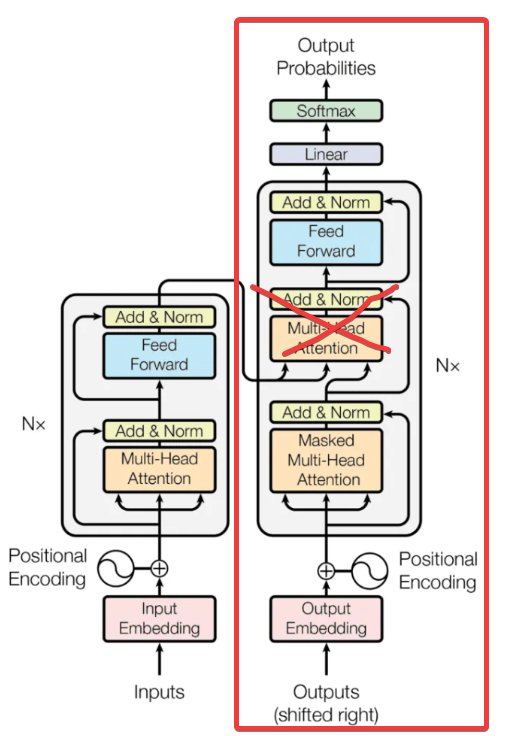

**But you will understand how you could implement the rest (encoder part) as well.**

# |-> 3.1: Rebuilding the Prelude

Let's rebuild what we did in the Prelude section so we can build off of it but this time, without going into detail.

In [15]:
%reset -f

import torch
import torch.nn as nn
from torch.nn import functional as F

## Hyperparameters

Some parameters are unknown, even when you read the Prelude section. I will talk about them in a second.

In [16]:
batch_size = 32
block_size = 8

# How many iterations we will be doing in our training loop
max_iters = 5000

# The interval in which we want to calculate the loss. We cannot do that after each step.
eval_interval = 500

# We've used the learning rate before, but just without making it its own variable.
learning_rate = 1e-3

# We want the model to train and run on our GPU, that's why we declare our 'device' below. If we have no GPU
# we will just use the CPU. We will later ship all the data to that device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# The amount of iterations we use in our loss function. See below!
eval_iters = 200

torch.manual_seed(1337)

## Dataset

In [17]:
with open('/kaggle/input/the-bards-best-a-character-modeling-dataset/train.csv', 'r', encoding='UTF-8') as f:
    text = f.read()
print(text[:150])

text
"First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to fami


## Tokenizer

In [18]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

lookup_table_in = { ch:i for i,ch in enumerate(chars)}
lookup_table_out = { i:ch for i,ch in enumerate(chars)}

encode = lambda s: [lookup_table_in[c] for c in s] # Encoder
decode = lambda l: ''.join([lookup_table_out[i] for i in l]) # Decoder

# Actually tokenize the dataset
data = torch.tensor(encode(text), dtype=torch.long)
print(data[:150])

tensor([59, 44, 63, 59,  0,  3, 19, 48, 57, 58, 59,  1, 16, 48, 59, 48, 65, 44,
        53, 11,  0, 15, 44, 45, 54, 57, 44,  1, 62, 44,  1, 55, 57, 54, 42, 44,
        44, 43,  1, 40, 53, 64,  1, 45, 60, 57, 59, 47, 44, 57,  7,  1, 47, 44,
        40, 57,  1, 52, 44,  1, 58, 55, 44, 40, 50,  9,  0,  0, 14, 51, 51, 11,
         0, 32, 55, 44, 40, 50,  7,  1, 58, 55, 44, 40, 50,  9,  0,  0, 19, 48,
        57, 58, 59,  1, 16, 48, 59, 48, 65, 44, 53, 11,  0, 38, 54, 60,  1, 40,
        57, 44,  1, 40, 51, 51,  1, 57, 44, 58, 54, 51, 61, 44, 43,  1, 57, 40,
        59, 47, 44, 57,  1, 59, 54,  1, 43, 48, 44,  1, 59, 47, 40, 53,  1, 59,
        54,  1, 45, 40, 52, 48])


## Train/Test Split

In [19]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

## Data Loading

There is a tiny change from the method we used in the Prelude: we have to transport the data to our new 'device' variable (to our GPU at best).

In [20]:
def get_batch(split):
    '''
    A function that returns a data batch for training for any given split (train or validation). 
    '''
    data = train_data if split == 'train' else val_data
    # Here we create 4 starting indexes (equal to batch_size) of the 4 data batches we want to sample 
    index_x = torch.randint(len(data) - block_size, (batch_size,))
    # Get the context data
    x = torch.stack([data[i : i+block_size] for i in index_x])
    # Get our targets
    y = torch.stack([data[i+1 : i+block_size+1] for i in index_x])
    # NEW LINE:
    x, y = x.to(device), y.to(device)
    return x,y

## Loss Estimation

This is a new function which we haven't talked about before.

When we calculate a "loss", we want to determine how off the models predictions are in comparison to the targets. Since our tokenizer transformed all text into numbers, this also works with "text". In the Prelude, all we did was take one batch and see how wrong the predictions were. This can be very noisy, it's much more sincere to look at multiple batches of predictions, calculate each loss and average them out. That's what we use our new variable **eval_iters** for. Since in this case we set the variable to 200, we will use 200 batches, calculate the loss and then return the averaged loss as our realy loss within the training loop.

In [21]:
# This tells torch that it doesn't need to store the intermediate values as we will be doing no backpropagation.
# Saves a lot of memory.
@torch.no_grad()
def estimate_loss(_model):
    out = {}
    _model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = _model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    _model.train()
    return out

## Bigram Model

Our super simple Bigram model which we built in the Prelude. We will step by step modify this model so that, in the end, we can call it a Transformer.

In [22]:
# Our model inherits the pytorch Module module
class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # The matrix below is a 66 x 66 matrix, so basically all tokens within
        # our vocab times all tokens within our vocab
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    # This is not a feed forward layer, but gets us the next logits we need for the generate method
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    # A method that will generate the next token in our timeline. So like:
    # "A ca" -> "A cat" -> "A cat " -> ...
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # Get the current predictions. This "self" call will automatically call 
            # our "forward" method above
            logits, loss = self(idx)
            # focus only on the last time step (token)
            logits = logits[:, - 1, :]
            # Do a softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample from the prob distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append the next probable index (=token) to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

## Create the Model

In [23]:
def get_model():
    model = BigramLanguageModel()
    m = model.to(device) # This model will now also be transported to our device
    return model, m
model, m = get_model()

## Training loop

In [24]:
def train(_model):
    optimizer = torch.optim.AdamW(_model.parameters(), lr=learning_rate)

    for iter in range(max_iters):

        # every once in a while, evaluate the loss on train and val set
        if iter % eval_interval == 0:
            losses = estimate_loss(_model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch('train')
        logits, loss = _model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
train(model)

step 0: train loss 4.5956, val loss 4.5718
step 500: train loss 4.0624, val loss 4.0560
step 1000: train loss 3.6407, val loss 3.6472
step 1500: train loss 3.3293, val loss 3.3335
step 2000: train loss 3.0869, val loss 3.1000
step 2500: train loss 2.9069, val loss 2.9279
step 3000: train loss 2.7833, val loss 2.7937
step 3500: train loss 2.6962, val loss 2.7156
step 4000: train loss 2.6288, val loss 2.6524
step 4500: train loss 2.5834, val loss 2.6109


## Inference

In [25]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))




By are ajMybu;
'ee h nd, asJ

Whain anay?GLABuRufN,.
RLAREXK:ZngoEXUTIsofett pres u-sato cWheWoZnd tve GOf is emes by yo nto
Xn.
AELUTe hay pand l w:
I:

YCad. hevd,Dumelom kis GERDYOnu ssofiA:
Vjk meFrofouVialir kikimEET: thisht,Y be hean ostou my


**Good, this result was the end of the Prelude section.** It's a tiny bit like Shakespear, isn't it? Well, not really. **That's why we we are now going to start building the Transformer.**

# |-> 3.2: Self-Attention

------------

This is going to be a longer section, as the Self-Attention is arguably the most relevant part of the Transformer. That's why the paper was also called "Attention Is All You Need". I am not going to implement the "final" version of the layer directly; I instead want to work my way up through multiple, more simpler versions before then showing you the final one. **If your only interested in the final Self-Attention Head**, jump to the [Final Version: Implement a Self-Attention Head](#finalHead) section.

As I've tried to showcase multiple times: we need our tokens to communicate with each other. Otherwise, we are stuck with predicting one token on the basis of just the one before that, which is not sufficient. **To make the tokens talk, we implement the Self-Attention.**

The inuition is fairly trivial. Consider the following example:

In [26]:
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

We create a 4x8x2 matrix (B, T, C) where:
- B is the amount of batches (here: 4)
- T is the timeseries, so how many tokens are we looking at per batch (we've talked about this in the Prelude)
- C is the channel, so basically a field where we can store information for each point in the sequence. You will see how we use it later.

We have up to 8 tokens in one batch, which aren't talking to each other. What we want is: when e.g. predicting the token at position *4*, we want to do so with the information from the tokens at position *1,2 and 3*. A bit more formalized:

$$pred(t) = context(t_{1}, t_{t-1})$$


We **do not** want any information from the future, so positions *5,6,7 and 8* are out of the picture. Otherwise, we are not training the model to predict the future sequence. 

**How do we do get the context?**

## Version 1: Averaging the Context

A very simple approach would be to simply take the average of the channels of the predecessor tokens, so that it would become something like a feature vector that summarizes **me in the context of the other tokens beforehand.**

That would be a very weak communication though. We are losing e.g. spacial relations of the tokens, which are crucial for generating coherent texts. **Still, let's stick with it for now and write it out**.

In [27]:
xbow = torch.zeros((B,T,C)) # bow = back of words
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1]
        xbow[b,t] = torch.mean(xprev, 0) # Take the average
        
print(x[0])
print('\n')
print(xbow[0])

tensor([[ 0.8186, -1.9132],
        [ 1.0982,  3.0775],
        [ 1.0093,  0.5200],
        [ 1.0712,  0.6197],
        [ 1.1729,  0.6705],
        [-0.1689,  0.4937],
        [-0.4970,  1.3527],
        [ 0.1195, -1.4906]])


tensor([[ 0.8186, -1.9132],
        [ 0.9584,  0.5822],
        [ 0.9754,  0.5614],
        [ 0.9993,  0.5760],
        [ 1.0340,  0.5949],
        [ 0.8335,  0.5780],
        [ 0.6435,  0.6887],
        [ 0.5780,  0.4163]])


Look at the first row of each matrix: they are equal. Why? Because we have no context before that. But look at the second row of the second matrix: **These are the averages of the first two rows of the first matrix.** The third row is the average of the first three rows and so on. **Also observe that we have 2 columns in our matrix per row**. These are the channels I've mentioned earlier. We are giving ourselves 2 "places" to store information foreach point.

**The problem:** This is very inefficient, because we are doing two nested loops over a matrix. **That's where a crucial mathematical trick comes to play for the Self-Attention layer: matrix multiplication.**

## Important Trick: Matrix Multiplication

Have a look at the following three matrices *a, b* and *c*, which is the multiplication of *a and b*.

In [28]:
torch.manual_seed(42)
a = torch.ones(3,3)
b = torch.randint(0, 10, (3,2)).float()
c = a @ b # The @ sign does a matrix multplication
print('a:')
print(a)
print('b:')
print(b)
print('c:')
print(c)

a:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
b:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c:
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


Looking at the top, left item in c, we can observe a 14. **Why?** Because we take the first row (dot product) of *a* and multiply it with the first column of *b* (dot product). Since *a* is only ones, we are only summing up the first column of *b* which results in 14. **How is that important?**

Let's look at matrix a again, but this time we only want the lower triangle portion of it.

In [29]:
a = torch.tril(torch.ones(3,3))
print(a)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])


See the triangle? Let's see what happens with *c* now.

In [30]:
c = a @ b
print('a:')
print(a)
print('b:')
print(b)
print('c:')
print(c)

a:
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
b:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c:
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


The top, left item in c is now only 2, because the first row of *a* contains [1, 0, 0] which means the first column of *b* is only 2 (when multiplying).

But look at the **second row of c**. Because we have the triangular form in a, the second row in *c* is the **sum of the first and second row of b**.

c: [8, 11] = b[2 + 6, 7 + 4]

We just calculated the sum without having to use loops and **we can do the very same with the average.** To do that, we change *a* to a triangular form again, but this time not filled with ones, but so that each **row summed up** equals 1. See below.

In [31]:
a = a / torch.sum(a, 1, keepdim=True)

c = a @ b
print('a:')
print(a)
print('b:')
print(b)
print('c:')
print(c)

a:
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c:
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Look at a and observe the triangular, average format. With that, **see how the matrices b and c behave exactly like our B,T,C tensors from earlier, but this time we didn't use any nested loops to calculate the average?**

That's an important trick which massively increases the performance. With that knowledge, let's create version 2 of our Self-Attention.

## Version 2: Averaging the Context with Matrix Multiplication

Let's apply the trick to our token averaging.

In [32]:
wei = torch.tril(torch.ones(T, T)) # We ge the triangular matrix
wei = wei / wei.sum(1, keepdim=True) # And average it out
wei # This is now our a from before

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

And calculate xbow again, but this time without loops. We'll call it xbow2

In [33]:
xbow2 = wei @ x
xbow[0], xbow2[0]

(tensor([[ 0.8186, -1.9132],
         [ 0.9584,  0.5822],
         [ 0.9754,  0.5614],
         [ 0.9993,  0.5760],
         [ 1.0340,  0.5949],
         [ 0.8335,  0.5780],
         [ 0.6435,  0.6887],
         [ 0.5780,  0.4163]]),
 tensor([[ 0.8186, -1.9132],
         [ 0.9584,  0.5822],
         [ 0.9754,  0.5614],
         [ 0.9993,  0.5760],
         [ 1.0340,  0.5949],
         [ 0.8335,  0.5780],
         [ 0.6435,  0.6887],
         [ 0.5780,  0.4163]]))

As you can see, the two matrices are exactly the same. We will frequently use this mathematical trick, so it's useful to understand it.

## Version 3: Adding Softmax

Before implementing the final version of the Self-Attention layer, let's look at another version before that by using softmax. Have a look at the following code and its output:

In [34]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
print(wei)
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
wei, xbow3[0]

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
         [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
         [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]]),
 tensor([[ 0.8186, -1.9132],
         [ 0.9584,  0.5822],
         [ 0.9754,  0.5614],
         [ 0.9993,  0.5760],
         [ 1.0340,  0.5949],
         [ 0.8335,  0.5780],
         [ 0.6435,  0.6887],
         [ 0.5780,  0.4163]]))

Again, we have the same results as before, but this time we didn't "average" the rows in a traditional way, but instead used the Softmax function to do that for us, which is what we will use in the final version of the Self-Attention layer. **Why?**

- Look at the weights (=wei) at the beginning. It's a triangular matrix where the lower triangle consists of 0s. **This is telling us how far back the context for this specific token prediction goes.**
- Look at the -INF in the top triangle. **This is telling us which tokens we musn't use for our prediction as they lie in the future.**
- We then need the Softmax function to generate our weight matrix correctly.

## Long Story Short

*You can do weighted aggregations of your past elements, by using matrix multiplication in the lower triangle fashion. The elements within the lower triangle tell you how much of each element fuses into the prediction of the next element.*

## <a name="finalHead"></a>Final Version: Implement a Self-Attention Head

Let's look at the following code again, which should be familiar to you by now.

In [35]:
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=1)
print(wei)
out = wei @ x
out.shape

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


torch.Size([4, 8, 32])

Observe that I drastically increased the number of channels per token, so the amount of information we can store is bigger. **Also, think about the weights matrix for a moment and how it looks above**. What we did so far was achieving a uniform average over the past tokens, but this isn't really the behaviour we want. We don't want uniform context weights as the tokens themselves do not find each other equally important. **We need those weights to be data dependant and that is the problem which the final Self-Attention layer solves.**

It does so with the following steps:

- Every single token at each position will emit two vectors: a **query** and a **key**.
    - The query vector tells us "What am I looking for?"
    - The key vector tells us "What do I contain?"
- The way we get affinities between tokens is by doing dot products between these vectors.
- My *query* does dot products with all the *keys* of the other tokens and **that dot product becomes our new weight(=wei) matrix.**
- If the key and the query are much alligned, the resulting dot product will be bigger and it will hence tell us the affinity between these two tokens are greater.

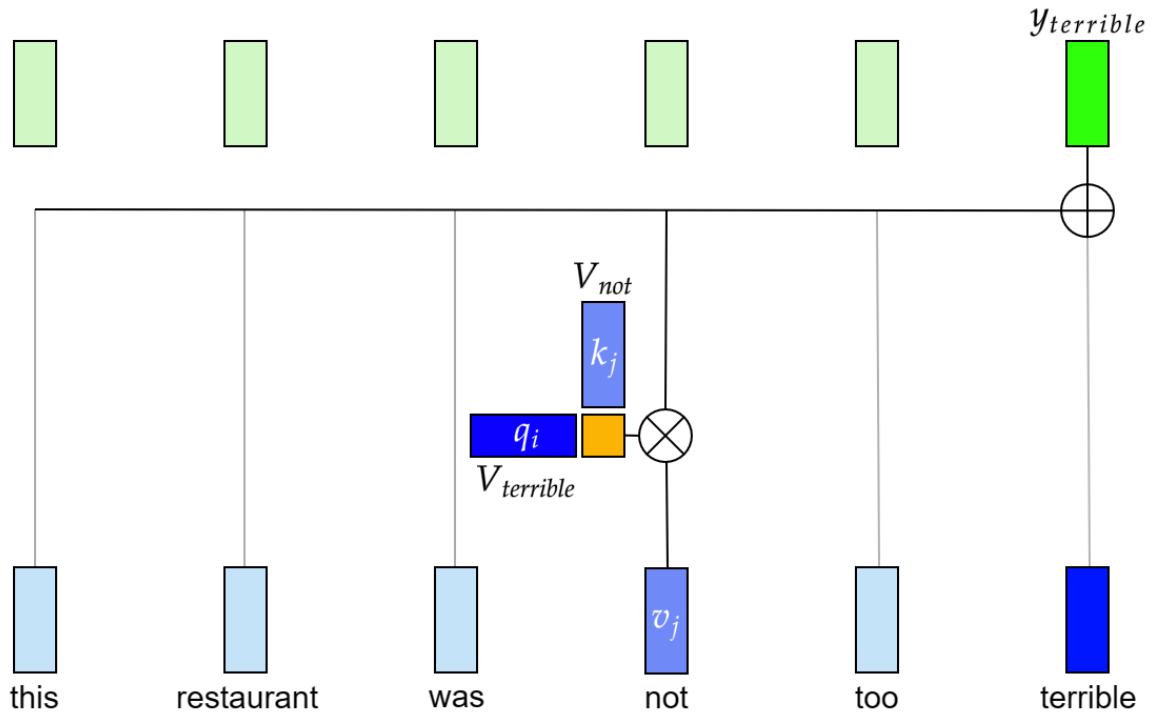

The image above tries to visualize what I've just tried to explain. Foreach token in our batch, we look at the other tokens **before that** and calculate the importance via the key and query vector. The image shows this for the token "terrible" and the reason why "not" is being more darker than the rest is because this token has a huge impact on "terrible" as it moderates it.

Let's use this knowledge now to implement a **single Self-Attention "Head"**.

In [36]:
# We know this ===============
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C) # Just some random tokens
# ============================

In [37]:
# Here we insert the head.
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, 16)
q = query(x)  # (B, T, 16)

We are defining two linear layers, one for the key and one for the query. The Linear module in PyTorch is essentially a linear transformation (matrix multiplication followed by addition) of the input data.

We then create the two matrices *k* and *q* respectively for the key and query. Remember, we want to have a key and query foreach token and for now, **no communcation has happened yet**. Each token created it's own.

We will add the communication now:

In [38]:
# Here the magic happens, we calculate our weight matrix again
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

In [39]:
# We know this ===============
tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
print(wei[0])
out = wei @ x
out.shape

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)


torch.Size([4, 8, 32])

Look at our weight matrix now. Before, the lower triangle was just a uniform, average of each row, but this time it contains actual contextual information between tokens. 

There is one part still missing of the final head. When we do the aggregation, so: 

`out = wei @ x`

we dont actually take the tokens (x), we instead aggregate a third matrix besides the key and query, called the *value*. 

In [40]:
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False) 
value = nn.Linear(C, head_size, bias=False) # <----- HERE
k = key(x) # (B, T, 16)
q = query(x)  # (B, T, 16)
v = value(x) # <----- HERE

wei = q @ k.transpose(-2, -1) * head_size**-0.5 # <----- HERE
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
print(wei[0])
out = wei @ v # <----- HERE
out.shape

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6713, 0.3287, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5042, 0.2434, 0.2524, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1592, 0.2082, 0.2443, 0.3884, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2300, 0.0934, 0.1076, 0.1333, 0.4357, 0.0000, 0.0000, 0.0000],
        [0.0861, 0.1810, 0.2162, 0.1667, 0.2473, 0.1028, 0.0000, 0.0000],
        [0.1508, 0.1360, 0.1484, 0.1307, 0.1233, 0.1862, 0.1246, 0.0000],
        [0.2171, 0.0870, 0.0927, 0.0759, 0.2297, 0.1191, 0.1016, 0.0770]],
       grad_fn=<SelectBackward0>)


torch.Size([4, 8, 16])

And now observe how the output of this single head is 4x8x**16** which is the **head_size** we declared ealier. But wait, **what happened with the *wei* calculation?** We simply damped the values within the weight matrix. Why? Because Softmax is a pretty steep function. Look at the following operation:

$$softmax([0,1, -0.2, 0.3, -0.2, 0.5]) = [0.1925, 0.1426, 0.2351, 0.1426, 0.2872]$$

You can see a pretty even distribution. Now let's multiply our input by 8 and hence make the values just a bit bigger.

$$softmax([0,1, -0.2, 0.3, -0.2, 0.5]*8) = [0.0326, 0.0030, 0.1615, 0.0030, 0.8000]$$

Observe how the Softmax function causes our output vector to be essentially 0 except for the last entry which is 0.8. In terms of tokens, this would mean that we will really only be looking at one token per token, which is not a behaviour we want. Hence, we damp down the values in the matrix so it doesn't happen.

**As a last note**, because I think it is so beautifully simplistic:

The terms "Encoder" and "Decoder" are often mentioned when talking about Attention blocks. *(Note: I'm not referring to the Tokenizer encoder/decoder we implemented earlier in the Prelude).* I want you to look at the following code snippet again:

In [41]:
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

This is a **decoder** because we do not look into the future. We set the matrix to be in a triangular shape. You can create an **encoder** from this by just adding one symbol:

In [42]:
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
tril = torch.tril(torch.ones(T, T))
#wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

**That's it.** By not forcing the matrix to be in a triangular shape, we let the tokens communicate in all directions, making this essentially an **encoder**.

## Closure

The Attention mechanism is a clever way to find contextual relations of tokens within blocks. I hope that after you've read this section, you see that it isn't that difficult to understand, nor to implement, which I'll show you in a bit.

**Also:** just a heads up that for this generative transformer, we don't want the tokens to look into the future, but for other cases, let's say Sentiment Analysis, we very much want to extract the additional information from the tokens after us to evaluate the Sentiment.

**The final code for a Self-Attention Head outlined in a class for future usage looks like this:**

In [43]:
class Head(nn.Module):
    '''A class that represents a single SE head'''
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=1)
        v=self.value(x)
        out = wei @ v
        return out

# |-> 3.3: Positional Encoding

------------

As off now, we have no information about the relative position of each token. This means we don't take into account where a token is relative to its neighbours. Even the attention mechanism doesn't encapsulate that. But for a text, the position of a word is crucial. Hence, we need a way to capture that information and inject it into our Transformer and we do that by adding positional encoding.

Let's do that by adjusting our **BigramLanguageModel class**:

(*Note that I also added the SE head into the model now*)

In [44]:
#  -------------- CHANGE (1) -------------- 
# We need a new hyperparameter
n_embd = 32 # = Number of Embedding dimensions
#  ----------------------------------------

class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        print("Created Bigram Model with SE head")
        super().__init__()
        #  -------------- CHANGE (2) -------------- 
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size) # language model head
        #  ----------------------------------------
    
    def forward(self, idx, targets=None):
        
        # logits = self.token_embedding_table(idx) # Old
        
        #  -------------- CHANGE (3) -------------- 
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb
        x = self.sa_head(x) # Apply one SE head
        logits = self.lm_head(x) # (B,T,vocab_size)
        #  ----------------------------------------
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            #  -------------- CHANGE (4) -------------- 
            idx_cond = idx[:, -block_size:]
            #  ----------------------------------------
            logits, loss = self(idx_cond)
            logits = logits[:, - 1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

Let's look at each change.

**1)** We define a new hyperparameter for our embedding dimension which we use in change 2.

**2)** **This one is important**. Before, we simply had a list of tokens foreach token (vocab_size x vocab_size). In the forward method, we then simply got the corresponding token embedding by index and predicted with that. That means each time we predicted something, we got the complete vocab size and then, funny enough, **only looked at the very last token before the current one** to make our prediction.
<br/>
**What we now do instead is:** Foreach token in our vocab, we define an embedding space. So instead of storing the whole vocab foreach token, we want to store an embedding of size 32. Within this embedding **we store contextual data instead**. These embedding values can be seen as a representation of the token in a continuous vector space. When you pass an index (representing a token) through the embedding layer, the layer looks up the corresponding row in the embedding table and returns the associated embedding vector. The idea is that similar tokens in the vocabulary should have similar embeddings, and the model learns these representations during the training process. We do the same for positional information (*position_embedding_table*).

**3)** In change 3, we adapt the forward method to now work with embedding vectors instead of logits directly. These changes are directly connected to change 2 and our new logit, which we predict on, **is a combination of contextualized and postional token embedding.**

**4)** We need to clamp the context to make sure we never fit in more context than allowed in our token block. Before we had the whole vocab in there, but only ever used a single token so it didn't make much sense anyway.

# |-> 3.4: Interim Results

-----------

With the addition of one Self-Attention Head, let's train our model again and look how it performs.

In [45]:
del model, m
model, m = get_model() 
train(model)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))

Created Bigram Model with SE head
step 0: train loss 4.2768, val loss 4.2823
step 500: train loss 2.5369, val loss 2.5658
step 1000: train loss 2.3918, val loss 2.4206
step 1500: train loss 2.3184, val loss 2.3761
step 2000: train loss 2.2840, val loss 2.3240
step 2500: train loss 2.2549, val loss 2.2876
step 3000: train loss 2.2279, val loss 2.2672
step 3500: train loss 2.2143, val loss 2.2475
step 4000: train loss 2.1801, val loss 2.2289
step 4500: train loss 2.1715, val loss 2.2084

Bue se beacecanve'dvin the as lal O:
My; yat de,
Ffy, mis,
Bke.

LWave as fet tpeal ursate chorpoled tve my tis,
CDY by yo llo
Kaver, ste hay pand livelces,
Whde heve,
QUCES:
Twh Gll cheu ss fo.

Fe om whis suin to kikime od this; th but lan, ato amy


As you can see, the loss improved from originally ~2.5-2.6 which means the SE head does help, but we still get rubbish. We need to finish the Transformer first to get better results.

# |-> 3.5: Multi-Head Attention

-----------

What do you do when one Head isn't enough? Exactly: **add more SE heads.**

After we've understood and implemented a head before, a multi-head attention is fairly trivial. It's just **multiple heads in parallel**.

In [46]:
class MultiHeadAttention(nn.Module):
    '''multiple heads running in parallel'''
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        
    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

We simply create a list of heads and, in the forward method, **concatenate all of the outputs** over the channel dimension. Let's adjust our model class accordingly.

In [47]:
n_embd = 32

class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        print("Created Bigram Model with multiple SE heads")
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # self.sa_head = Head(n_embd) # ---> Old
        # Since we have 4 heads now, we must set the head_size to 8 to get a final
        # channel vector of dimension 32 (4*8) which we require.
        self.sa_heads = MultiHeadAttention(4, n_embd//4)
        self.lm_head = nn.Linear(n_embd, vocab_size) # language model head
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb
        x = self.sa_heads(x) # Apply all attention heads
        logits = self.lm_head(x) # (B,T,vocab_size)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, - 1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

Let's run it and see how it works now.

In [48]:
del model, m
model, m = get_model() 
train(model)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))

Created Bigram Model with multiple SE heads
step 0: train loss 4.2582, val loss 4.2543
step 500: train loss 2.2000, val loss 2.2292
step 1000: train loss 1.5232, val loss 1.5391
step 1500: train loss 1.2128, val loss 1.2318
step 2000: train loss 1.0429, val loss 1.0604
step 2500: train loss 0.9215, val loss 0.9323
step 3000: train loss 0.8275, val loss 0.8545
step 3500: train loss 0.7755, val loss 0.7868
step 4000: train loss 0.7039, val loss 0.7339
step 4500: train loss 0.6695, val loss 0.6871


Bkee'lxe I:
And, in enous, fucrigs sourencolds jepln Voorn cace dutay we ish cow.
The forewle, forne.

May tht to way thises e thy; the thire sis o medw weatere ODTEROL Rillle,
HORK:

O'ddath, thocrok thir fow.
ASehe ble plar mat ut, are,

F ID ungh


We further improve the loss and I can see some words that make sense, but we're still not there.

# |-> 3.6: Feed Forward

-----------

Have a look at the architecture outlined within the paper.

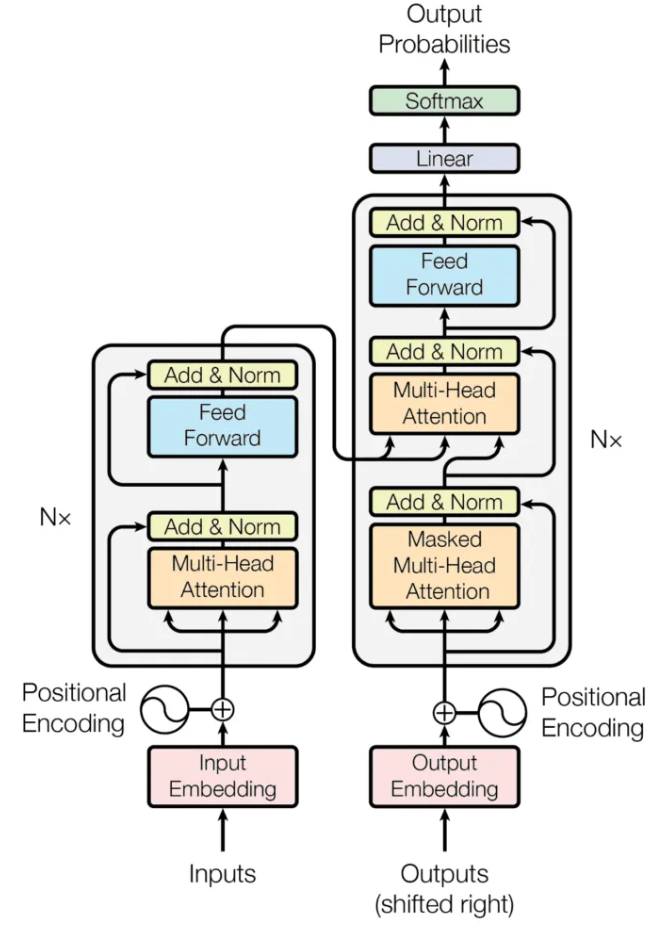

We can see some of the components which we already built like the Encodings and Masked Multi-Head Attention *(there is also another Multi-Head Cross Attention layer to an encoder (left on the image) which we won't be implementing now)*  but we also see a Feed Forward layer which we need to add now. And then all of this is grouped into a unit which is repeated N times.

**Let's add the Feed Forward layer:**

In [49]:
class FeedForward(nn.Module):
    '''a linear layer followed by non-linearity'''
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

So far, we had the Multi-Headed Self Attention but we calculated the logits way too fast. The tokens looked at each other, but didn't really had the "time" to learn from each other. We change that now by adding a FF layer to train the tokens to actually do that.

**Our adjusted model looks like this now:**

In [50]:
n_embd = 32

class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        print("Created Bigram Model with multiple SE heads and FF layer")
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4)
        # Add the FF layer <---------------
        self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb
        x = self.sa_heads(x)
        # Add the FF layer <---------------
        x = self.ffwd(x)
        
        logits = self.lm_head(x) # (B,T,vocab_size)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, - 1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

Notice how we apply the FF per token, so all tokens run through this layer independently. **We let the tokens think on the data individually.**

In [51]:
del model, m
model, m = get_model() 
train(model)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))

Created Bigram Model with multiple SE heads and FF layer
step 0: train loss 4.1746, val loss 4.1748
step 500: train loss 2.1579, val loss 2.2029
step 1000: train loss 1.4762, val loss 1.5304
step 1500: train loss 1.1645, val loss 1.2053
step 2000: train loss 0.9172, val loss 0.9398
step 2500: train loss 0.7581, val loss 0.7930
step 3000: train loss 0.6556, val loss 0.6841
step 3500: train loss 0.5894, val loss 0.6065
step 4000: train loss 0.5420, val loss 0.5585
step 4500: train loss 0.5123, val loss 0.5328

MOf is mij.
Iaf-lunge bles aldal nato bulgren, omelearspiwshitrerw, a oulwaichitest prts, war-vhelth, a roly ree, blr talst Dh nocy tho hiitirruty oud?
OUCLOurse, l?B, abide no injinuds ande Ovitle thawhe dre sen mosans Bol frudomoter.

Ok tipsem'hle


**The model is getting better and better, we keep on building.**

# |-> 3.6: Nx Blocks

-----------

Have a look at the following excerpt of the Transformer architecture again. See how we implemented the Feed Forward now as well and as the next step, you can see that all of our operations we've just done are being encapsulated by a block. This block is then repeated N times.

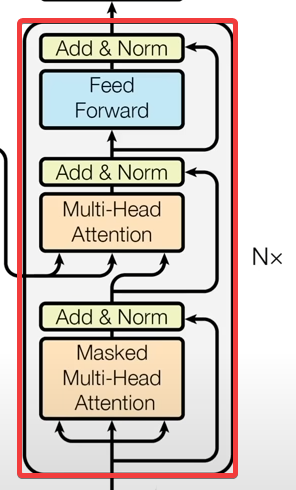

**Let's add that now as well** by implementing a new *Block* class to your model.

In [52]:
class Block(nn.Module):
    '''A transformer block that first allows communcation between tokens and then computation'''
    
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        # Coomuncation
        self.sa = MultiHeadAttention(n_head, head_size)
        # Computation
        self.ffwd = FeedForward(n_embd)
        
    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

As you can see, a block basically wraps two operations: a communcation of our tokens (SE heads) and the computation/learning of these results via the FF layer. **That's one block.** We will now add this block to our model and see how it performs. 

*(The results may surprise you)*

In [53]:
n_embd = 32

class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        print("Created Bigram Model with Blocks")
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        # The below gets replaced --------------------
        #self.sa_heads = MultiHeadAttention(4, n_embd//4)
        #self.ffwd = FeedForward(n_embd)
        # With this: ---------------------------------
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        # ---------------------------------------------
        
        self.lm_head = nn.Linear(n_embd, vocab_size)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x) # <--------- Add the blocks to our forward.
        # Delete the sh heads and ffwd parts. These are now in our blocks.
        
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, - 1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

We just addded 3 blocks to our model. Let's run it:

In [54]:
del model, m
model, m = get_model() 
train(model)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))

Created Bigram Model with Blocks
step 0: train loss 4.1968, val loss 4.1956
step 500: train loss 2.3136, val loss 2.3064
step 1000: train loss 1.7045, val loss 1.7111
step 1500: train loss 1.2291, val loss 1.2200
step 2000: train loss 0.9569, val loss 0.9804
step 2500: train loss 0.7605, val loss 0.7857
step 3000: train loss 0.6939, val loss 0.7089
step 3500: train loss 0.5763, val loss 0.5931
step 4000: train loss 0.5641, val loss 0.5672
step 4500: train loss 0.4947, val loss 0.4935

Anllllg
Toraadap
o
CWveou,.

LRT
N I r -ue utlk mp icin rbeke fis we houllbericehy'lg;ew, hat
LLoY
uWm hindiv d;lt'lede thy ne.o?t n sm nmeers d t.
AN ERoCBsF nt voad sme hos anthero't kad.

G
OoOT Ih t
EB:
GLa hliv s,
I hu
Dints he meet:

CBIN:
NOR:


These results aren't very good. While the loss went down a bit, the text itself looks more janky than before. **The problem** may be that our NN gets pretty deep by now and these deep NNs tend to suffer from optimization issues.

Hence we will add one more component to our Transformer which tries to fix this issue.

# |-> 3.7: Add & Norm

-----------

Have a look at the following snippet:

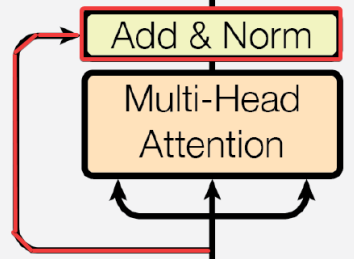

You see the arrow that goes around the SE head and comes back afterwards. These are called Skip Connections or Residual Connections and they were introduced in 2015 [here](https://arxiv.org/abs/1512.03385).

These connections were introduced to address the vanishing gradient problem. In a typical NN layer, the output is computed as the weighted sum of the input features passed through an activation function. In a residual block, the output is the sum of the input and the output of the layer, bypassing the need for the activation of the layer. So without a residual connection, you'd have e.g.:

$$Output = ReLU(Conv(x,W))$$

and with the residual connections, you get:

$$Output = x+ReLU(Conv(x,W))$$

See how this is shown in the image above. Instead of just taking the output of our SE head, we add that output to the original input (x). We do that because the presence of residual connections help in mitigating the vanishing gradient problem, making it easier for gradients to flow through the network during backpropagation.

**Let's add them to our blocks, FF layers and SE heads:**

In [55]:
class Block(nn.Module):
    '''A transformer block that first allows communcation between tokens and then computation'''
    
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        
    def forward(self, x):
        x = x + self.sa(x) # <------- We add x + ...
        x = x + self.ffwd(x) # <----- Here as well
        return x
    
    
class MultiHeadAttention(nn.Module):
    '''multiple heads running in parallel'''
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        
    def forward(self, x):
        # This is the output of the SE itself, which we simply returned before 
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # Now we want to project this outcome which is just a linear transformation.
        out = self.proj(out)
        return out
    
    
class FeedForward(nn.Module):
    '''a linear layer followed by non-linearity'''
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # <---- The paper states that the inner-layer has 4x the dimensionality of the input/output. So we add that as well. 
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd) # <------ Add the projection here as well
        )
    
    def forward(self, x):
        return self.net(x)

**Let's run it again.**

In [56]:
del model, m
model, m = get_model() 
train(model)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))

Created Bigram Model with Blocks
step 0: train loss 4.7805, val loss 4.7827
step 500: train loss 1.0290, val loss 1.0484
step 1000: train loss 0.5438, val loss 0.5451
step 1500: train loss 0.3967, val loss 0.3983
step 2000: train loss 0.3569, val loss 0.3657
step 2500: train loss 0.3356, val loss 0.3449
step 3000: train loss 0.3207, val loss 0.3364
step 3500: train loss 0.3227, val loss 0.3301
step 4000: train loss 0.3141, val loss 0.3215
step 4500: train loss 0.3093, val loss 0.3141

AOHHHHWARG I INIXOERDWALINIGHAR:
Betto it brou dou. Shis hit:
SWUSS:
Joven with
Doulde'dlad, ulloir hould hanghee, God, theltfoul shim,
Gomchalp inende,
GKINRDord Hmool,
Kld blour houk:
Whas an, hand hacak:
Buks thoanded dhof whelligh lor
Coufdound
H


See how we massively improve the losses? Also, the text is getting closer and closer to being Shakespear, but we are still not done.

## Layer Norm

See how in the image above we have the "Add & **Norm**" layer? We've just added the "Add" layer, let's also add the Norm-layer which was introduced [here](https://arxiv.org/abs/1607.06450). 

**The idea is pretty simple:** Normalization helps in bringing the input values to a standard scale, making optimization more stable and efficient. You could image how non-standardized values (huge jumps in between them e.g.) could screw up the layers.

**Before that**, it needs to be said that since the time the Transformer got first introduced, little has been changed in its architecture. One thing that has changed though is the placement of the **Norm-Layer** (Not the Add-Layer). In the paper and the image above, this layer gets applied **after** the transformations, but we are going to apply them **before** the transformations. That's also how we are going to implement it. Luckily, pytorch provides a very easy to use function to norm a layer.

In [57]:
class Block(nn.Module):
    '''A transformer block that first allows communcation between tokens and then computation'''
    
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd) # <----- Add the first layer norm
        self.ln2 = nn.LayerNorm(n_embd) # <----- Add the second layer norm
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # <---- Apply the first norm *before* the sa head
        x = x + self.ffwd(self.ln2(x)) # <---- Apply the second norm *before* the ff
        return x
    
    
n_embd = 32

class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        print("Created Bigram Model with Blocks and layer norm")
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            nn.LayerNorm(n_embd) # <----- Add the layer norm to the end of our blocks
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, - 1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

Let's train again!

In [58]:
del model, m
model, m = get_model() 
train(model)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=250)[0].tolist()))

Created Bigram Model with Blocks and layer norm
step 0: train loss 4.3440, val loss 4.3576
step 500: train loss 1.0113, val loss 1.0234
step 1000: train loss 0.4872, val loss 0.4988
step 1500: train loss 0.3825, val loss 0.3955
step 2000: train loss 0.3363, val loss 0.3437
step 2500: train loss 0.3143, val loss 0.3230
step 3000: train loss 0.3186, val loss 0.3250
step 3500: train loss 0.2963, val loss 0.3065
step 4000: train loss 0.2939, val loss 0.3058
step 4500: train loss 0.2953, val loss 0.3026

BPzBOO, Wiswar ethit! CEOONMES:
My lenow, the nows amne ime in wis wose pe so;NTICH:
Domerar a he him-:
Thir, as hitest ake prou a to trowr, welve bepomy as inswey an murt ad thand lil sf somemt sapl Se heasd of I fek!
The traud pnswer hatim theer di


We got the loss down to under 0.3 for the first time now, which is really nice.

# |-> 3.8: Closure

-----------

We now have pretty much all the components of our Transformer in place to make it speak like Shakespear. In the next section, we will add and tweak some minor hyperparameters or layers and finally **scale and train the Transformer.**

# 4 | Final Transformer

-------------
>**Here we are now**. We have built the Transformer and are now able to scale it up and train it. The Transformer should then produce what we all came for: Shakespear plays!

-------------

Below I added the complete code for the Transformer again into one cell. So if you haven't read any of the above and simply want to use the Transformer as it is: **Go ahead**.

For those that worked through the other sections: The code below will find some changes like added dropout, changed hyperparameters. Whenever I changed something, I commented it so all changes can be found that way. The code below can also be found on Andrej's GitHub repo [here](https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py).

**You better use a GPU for this.**

In [59]:
%reset -f

In [60]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# ========== Hyperparameters
batch_size = 64
block_size = 256 # We will predict the 257 token on the basis of the 256 before that now!
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4 # Bring down the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 # 384 / 6 = 64
n_head = 6
n_layer = 6
dropout = 0.2
# ==========================
torch.manual_seed(1337)

# Dataset
with open('/kaggle/input/the-bards-best-a-character-modeling-dataset/train.csv', 'r', encoding='UTF-8') as f:
    text = f.read()

# Tokenizer
chars = sorted(list(set(text)))
vocab_size = len(chars)
lookup_table_in = { ch:i for i,ch in enumerate(chars)}
lookup_table_out = { i:ch for i,ch in enumerate(chars)}
encode = lambda s: [lookup_table_in[c] for c in s] # Encoder
decode = lambda l: ''.join([lookup_table_out[i] for i in l]) # Decoder
data = torch.tensor(encode(text), dtype=torch.long)

# Train and Test Split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

# Data Loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# =========== Transformer Components:

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.dropout = nn.Dropout(dropout) # <----- Added Dropout!

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei) # <------ Added Dropout!
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        # Added the possibility to add heads per parameter and loop. That's it.
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout) # <----- More Dropout!

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out)) # <----- More Dropout!
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout), # <----- More Dropout!
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# We now don't have a BigramLanguage anymore
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Added the possibility to add heads per parameter and loop. That's it.
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    
# Train =============================
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

10.789698 M parameters
step 0: train loss 4.3572, val loss 4.3530
step 500: train loss 1.8962, val loss 1.9850
step 1000: train loss 1.5432, val loss 1.6851
step 1500: train loss 1.3938, val loss 1.5708
step 2000: train loss 1.3064, val loss 1.5116
step 2500: train loss 1.2422, val loss 1.4742
step 3000: train loss 1.1921, val loss 1.4688
step 3500: train loss 1.1480, val loss 1.4638
step 4000: train loss 1.1076, val loss 1.4580
step 4500: train loss 1.0648, val loss 1.4649
step 4999: train loss 1.0241, val loss 1.4768


In [61]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=1000)[0].tolist()))


Take the scorn.

KING HENRY VI:

Gaolern:
Say, my oath!

KING HENRY VI:
Be in the lion that your command; young mistress:
The time mist, which you mote forginges.
Gold keep of me suppy yes. Now, good forget!

HENRY BOLINGBROKE:
Yet ye sing, but it were an unhappy,
I'll stand their with your king.

KING RICHARD II:
Good Catesby, he wakes up, and your knee. Let's dead parted:
Is it the kind of my sons? and herefts are this:
Their thinks no marriage, advance as cerdom thy siege
As may executes.

CLAUDIO:
You may substant be, that with him!
If ever sanctuary
Let my apt heir to yours in enemy; but, hower
Than easenger thou wilt fair true, then go innock,
Are to child?

MAMILLIUS:
I shall be a banish as in him.
My modesman.

FLORIZEL:
Adieu! thou myself will for yours:
We would fright trust
That by Edward, whom know'st to speak again:
I would wrong on, on yours, bethink you,
Spy swim: let you see't first? I am your
friends you now, so late and billing, sir.

ROMEO:
Faith, I am thence; swind

Finally, we get something that resembles Shakespear! Keep in mind that we are building the Transformer on top of a **character-based tokenizer on a very small dataset**. Both isn't optimal, but it still produces, I find, remarkable results.

# 5 | Closure

-------------
>**Let's recap what we did**.

-------------

We implemented a generative, decoder Transformer that produces Shakespear-like plays **from scratch**. You can of course plugin any other dataset to see how the Transformer performs on that.

The Transformer predicts the next token, which in our case means the next character, on the basis of the last 256 tokens.

We've achieved this through the following, and I cannot stress this enough: **excellent** sources listed below which are worth reading/watching by itself:
- [Andrej Karpathy's YT tutorial](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=5214s)
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- [Jay Alammar's Blog](https://jalammar.github.io/illustrated-transformer/)

I sincerely hope that this notebook demystifies at least some aspect of the wide-spread Transformer architecture. **Feel free to ask questions or point out errors.**

Best,
*Kevin*